# Exploration

Dans cette partie on va donc explorer nos données afin de se familiariser avec le dataset.

Pour cette exploration j'avais au départ utilisé un attribut `version` qui me permettait d'avoir le même résultat par rapport à la version du script que je souhaite utiliser. Mais j'ai changé d'avis car je commençais à avoir trop de blocks "if" pour checker la version du code à utiliser.

En interne certaines actions étaient donc effectuées sur le dataset suivant la version. Cela me permettait de montrer ma démarche et la progression des traitements / explorations du dataset. Néanmoins maintenant je vais donc montrer les changements au fur et à mesure du notebook.

In [131]:
%load_ext autoreload
%autoreload 2
from src.dataset import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import cudf
import numpy as np

plt.style.use(['ggplot', 'https://raw.githubusercontent.com/AlanBlanchet/matplotlib_styles/master/vscode_blue.mplstyle'])

Dataset.init()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


src.dataset.dataset.Dataset

On peut faire une cellule de comparaison pour avoir un affichage des données brutes et des données traitées

In [103]:
topics = Dataset("topics1.csv")
topics.df.head()

,title,text,target,original_text,original_title
0,enforce attribute decoration of classes/methods,following on from my recent question on large...,c#|xml|serialization|coding-style|.net-attributes,following on from my recent question on large...,enforce attribute decoration of classes/methods
1,loading system.servicemodel configuration sect...,"using c# .net 3.5 and wcf, i'm trying to write...",c#|.net|xml|wcf|configurationmanager,"using c# .net 3.5 and wcf, i'm trying to write...",loading system.servicemodel configuration sect...
2,generics in c# & accessing the static members ...,my question concerns c# and how to access stat...,c#|generics|static|methods|data-access,my question concerns c# and how to access stat...,generics in c# & accessing the static members ...
3,how to make a histogram in ipython notebook us...,i'm trying to make a histogram of a simple lis...,python|ggplot2|ipython|jupyter-notebook|python...,i'm trying to make a histogram of a simple lis...,how to make a histogram in ipython notebook us...
4,implementation of the bidirectional graph search,i am trying to implement a bi-directional gra...,java|search|graph|artificial-intelligence|bidi...,i am trying to implement a bi-directional gra...,implementation of the bidirectional graph search


In [83]:
topics.df["text"].head()

0    following on from my recent question on  large...
1    using c# .net 3.5 and wcf, i'm trying to write...
2    my question concerns c# and how to access stat...
3    i'm trying to make a histogram of a simple lis...
4    i am trying to implement a  bi-directional gra...
Name: text, dtype: object

In [ ]:
def stemming(text):
    text = [Dataset.nltk_stemmer.stem(plural) for plural in text.split(" ")]
    return " ".join(text)

In [ ]:
def tokenize(text):
    text = nltk.word_tokenize(text)
    if version > 2:
        text = nltk.tokenize.MWETokenizer(
            [("c", "#"), ("f", "#"), ("+", "+")], separator=""
        ).tokenize(text)
    if version > 4:
        text = [t for t in text if t not in [*cls.stopwords, "n't"]]
        # Remove all single letters but keep C (as it is a language)
        text = [
            t for t in text if len(re.sub(r"['\"]", "", t)) != 1 or t == "c"
        ]
    else:
        text = [t for t in text if t not in cls.stopwords]
    if version > 1:
        reg = r"\w+" if version < 3 else r"\w+[#-+]*"
        text = nltk.RegexpTokenizer(reg).tokenize(" ".join(text))
    return " ".join(text)

In [105]:
topics.example(interactive=False, index=0)

Original ============================================
 following on from my recent question on  large, complex objects as a web service result . i have been thinking about how i can ensure all future child classes are serializable to xml. 
 now, obviously i could implement the  ixmlserializable  interface and then chuck a reader/writer to it but i would like to avoid that since it then means i need to instantiate a reader/writer whenever i want to do it, and 99.99% of the time i am going to be working with a  string  so i may just write my own. 
 however, to serialize to xml, i am simply decorating the class and its members with the  xml???  attributes (  xmlroot  ,  xmlelement  etc.) and then passing it to the  xmlserializer  and a  stringwriter  to get the string. which is all good. i intend to put the method to return the string into a generic utility method so i don't need to worry about type etc. 
 the this that concerns me is this: if i do not decorate the class(es) with the requ

J'avais donc au départ effectué plusieurs opération avec un système de version. Voici ce qui avait été fait :

- Remarquer les poncutation et les traiter
- Mise en place d'un système pour voir des examples (comme ci-dessus) mais de manière intéractive
- Remarquer la négation "n't" qui est présente
- Des mots qu'on aimerait peut être exclure car il n'apporte pas de plus value pour nos prédictions de tags comme par exemple : "problem", "error", "get", "code", "like"...
    - Pour régler le problème de la négation, je me suis d'abord dit qu'il serait bien de supprimer les chaînes qui ont une longueur égale à 1. Mais rappelons un instant que le langage C comporte 1 seul caractère. Il n'est donc pas possible de procéder comme cela. On aimerait possiblement conserver la négation car cela pourrait être utile pour une phrase du genre : "this is not Java". On gardera dans un premier temps cette négation.
    - Pour les mots qu'on aimerait exclure, je propose de mettre ces mots dans un fichier texte. Ils feront office de "stopwords" propres au projet (dans data/exclude.txt). On fera ce traitement si besoin par la suite 

Regardons les mots les plus communs et identifions les mots inutiles

In [107]:
freq = topics.most_common("commons_v0")
freq.most_common(20)

100%|██████████| 50000/50000 [00:06<00:00, 7991.44it/s]


[('', 4541145),
 ('\n', 431357),
 ('the', 351536),
 ('to', 229916),
 ('i', 215914),
 ('a', 154977),
 ('is', 129702),
 ('=', 126924),
 ('and', 121076),
 ('in', 116366),
 ('of', 94373),
 ('this', 72351),
 ('that', 71221),
 ('it', 70324),
 ('for', 68690),
 ('{\n', 59413),
 ('with', 54481),
 ('my', 53232),
 ('have', 49586),
 ('but', 49361)]

In [ ]:
topics.example(index=1)

--------------- index=0
Original ============================================
 following on from my recent question on  large, complex objects as a web service result . i have been thinking about how i can ensure all future child classes are serializable to xml. 
 now, obviously i could implement the  ixmlserializable  interface and then chuck a reader/writer to it but i would like to avoid that since it then means i need to instantiate a reader/writer whenever i want to do it, and 99.99% of the time i am going to be working with a  string  so i may just write my own. 
 however, to serialize to xml, i am simply decorating the class and its members with the  xml???  attributes (  xmlroot  ,  xmlelement  etc.) and then passing it to the  xmlserializer  and a  stringwriter  to get the string. which is all good. i intend to put the method to return the string into a generic utility method so i don't need to worry about type etc. 
 the this that concerns me is this: if i do not decorate the

On a donc tous les outils en main pour commencer à effectuer des analyses plus poussées et effectuer des tests sur nos données.

/home/alan/.cache/pypoetry/virtualenvs/oc--YnkylYD-py3.10/lib/python3.10/site-packages/cudf/core/series.py:3120: FutureWarning: `datetime_is_numeric` is deprecated and will be removed in a future release. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(


count    50000.000000
mean      1499.339720
std       1973.431863
min         14.000000
5%         223.000000
10%        309.000000
25%        521.000000
50%        932.000000
75%       1708.000000
90%       3087.100000
95%       4492.150000
97%       6390.075000
max      30867.000000
Name: text, dtype: float64

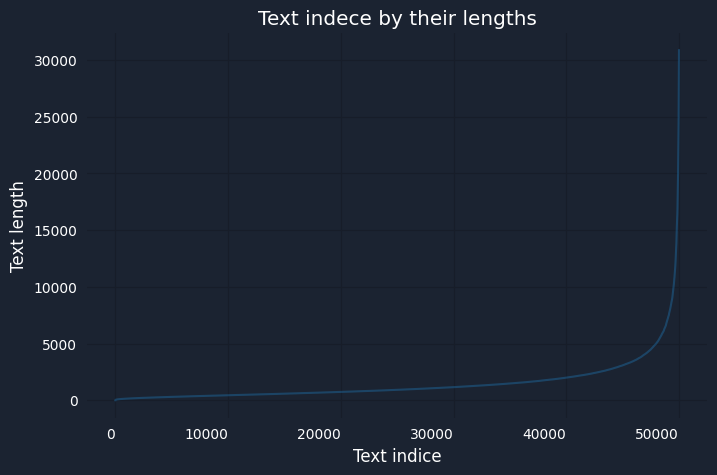

In [111]:
sententences_l = topics.df["text"].str.len().sort_values()
plt.figure(figsize=(8,5))
plt.title("Text indece by their lengths")
plt.xlabel("Text indice")
plt.ylabel("Text length")
sententences_l.reset_index(drop=True).to_pandas().plot()
sententences_l.describe(percentiles=[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975])

On remarque que quelques phrases sont très longues (2.5% avec l > 6992)

In [119]:
target_list = topics.df["target"].str.split("|").explode()
print(len(target_list.unique()))

18412


Text(0, 0.5, 'Targets')

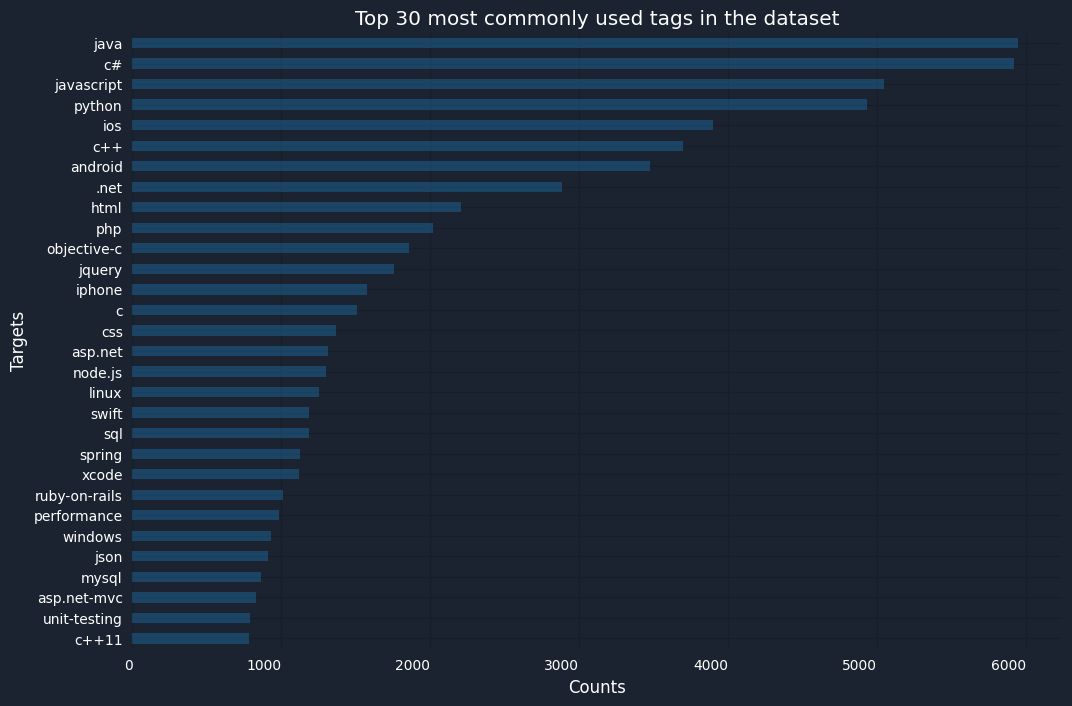

In [113]:
target_list_counts = target_list.value_counts().sort_values()
target_list_counts_tail = target_list_counts.tail(30)
target_list_counts_tail.to_pandas().plot.barh()
plt.title("Top 30 most commonly used tags in the dataset")
plt.xlabel("Counts")
plt.ylabel("Targets")

In [114]:
target_list_count_under_5 = target_list_counts[target_list_counts < 5]
target_list_count_under_5

gulp-protractor         1
regexkit                1
chain                   1
peerjs                  1
thephpleague-fractal    1
                       ..
mediastream             4
ontology                4
ormlite                 4
sortedmap               4
fread                   4
Name: target, Length: 13014, dtype: int32

Certains targets ne seront certainement pas simple à trouver car seulement 5000 ont une fréquence de 5 ou +. On peut donc se demander si conserver autant d'éléments est utile. On verra par la suite ce que l'on fait

5    32792
4    13095
3     3416
2      629
1       61
0        7
dtype: int64

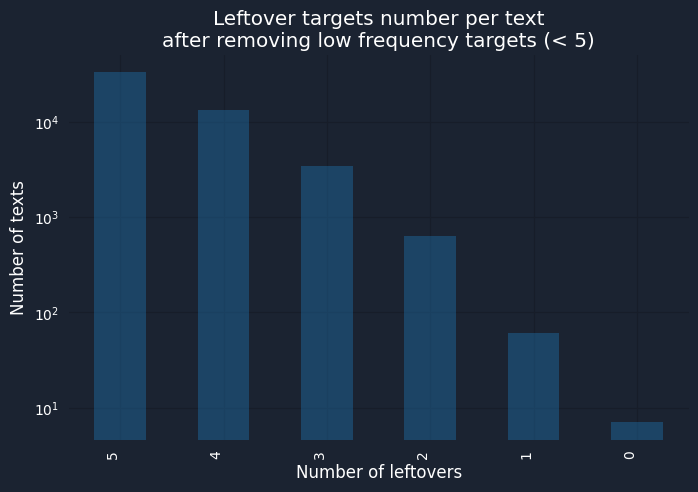

In [129]:
target_list_over_5 = target_list[~target_list.isin(target_list_count_under_5.index)]
target_list_over_5_index_counts = cudf.Series(target_list_over_5.index).value_counts()
target_list_over_5_target_count = target_list_over_5_index_counts.value_counts()
target_list_over_5_target_count[0] = len(topics.df) - target_list_over_5_target_count.sum()
plt.figure(figsize=(8,5))
plt.title("Leftover targets number per text\nafter removing low frequency targets (< 5)")
plt.yscale('log')
target_list_over_5_target_count.to_pandas().plot(kind="bar")
plt.xlabel("Number of leftovers")
plt.ylabel("Number of texts")
target_list_over_5_target_count

De plus, si on retirait ces targets, 7 lignes n'auraient plus de target du tout.

# Preprocessing avancé

## Itération 1

Dans cette partie on va regarder un peu plus notre dataset pour trouver des éléments mal preprocessé et noter l'index des phrases où l'on trouve ces cas

In [130]:
topics.example(index=1)

--------------- index=1
Original ============================================
 using c# .net 3.5 and wcf, i'm trying to write out some of the wcf configuration in a client application (the name of the server the client is connecting to). 
 the obvious way is to use  configurationmanager  to load the configuration section and write out the data i need. 
 var servicemodelsection = configurationmanager.getsection("system.servicemodel");
 
 appears to always return null. 
 var servicemodelsection = configurationmanager.getsection("appsettings");
 
 works perfectly. 
 the configuration section is present in the app.config but for some reason  configurationmanager  refuses to load the  system.servicemodel  section. 
 i want to avoid manually loading the xxx.exe.config file and using xpath but if i have to resort to that i will.  just seems like a bit of a hack. 
 any suggestions? 

Parsed ==============================================
 using c# .net 3.5 and wcf, i'm trying to write out some 

J'ai effectué ce traitement sur mon dataset local qui, en plus, a changé entre temps. Ce qui compte malgré tout sont les problèmes que j'ai pu y repérer

Voici donc les élément que nous devons maintenant traiter ainsi que l'index des phrases où le problème a été repéré :

- Les nombres (2, 14)
- Le "#" de C# est coupé (6)
- Attention à ne pas supprimer délaisser des nombres importants comme 64 (8)
- Dates peuvent être importantes (8)
- Le "++" de C++ est coupé (10,30)
- Il y a des urls (12,19,26,34,35,52,54)
- Des morceaux de code sans block de code (12,13,26,27,52,500)
- On supprime les balises "code" ce qui a pour effet de laisser certains textes un peu trop vide (14,19,20)

Constats :
- Certains éléments sont très compliqués à tagger même pour un être humain (9,11,500)
- La négation est importants dans certains contextes (10)
- Certains tags seront quasiement introuvable pour certaines situations. Il faudra habilement choisir une fonction de score (tous les exemples)

In [133]:
chars = ["#", "+"]
np.array([target
        for target in set(target_list.to_pandas())
        if pd.Series(chars).isin(list(target)).any()])

array(['j#', 'pkcs#1', 'visual-c++-2008', 'c++03', 'vb.net-to-c#',
       'c++-modules', 'effective-c++', 'visual-c++-2013', 'c#-2.0',
       'gtk#', 'c#', 'visual-c++-2008-express', 'visual-c++-2012',
       'visual-c++', 'c++-standard-library', 'visual-c++-2017', 'dev-c++',
       'c++20', 'pkcs#5', 'c++-winrt', 'c#-9.0', 'f#-3.1', 'c++11',
       'c++builder-6', 'c#-3.0', 'visual-c++-2015', 'c++builder-2010',
       'arduino-c++', 'g++4.9', 's#arp-architecture', 'c#-5.0', 'c#-6.0',
       'c++', 'turbo-c++', 'visual-c++-2010', 'c++26', 'f#', 'notepad++',
       'pkcs#8', 'objective-c++', 'c++builder-xe', 'gdi+',
       'c#-native-library', 'visual-c#-express-2010', 'c#-4.0',
       'libstdc++', 'c++17', 'managed-c++', 'pkcs#11', 'c#-to-vb.net',
       'c++filt', 'f#-data', 'x++', 'facebook-c#-sdk', 'f#-interactive',
       'c++-chrono', 'c++98', 'libc++', 'c++23', 'crypto++',
       'visual-c++-6', 'visual-c++-runtime', 'c#-10.0', 'com+',
       'c++-coroutine', 'clang++', 'spec#', 

On remarque que beaucoup de targets ont des version (ex: "c++-32") associées à leur nom. J'ai bien peur que le fait que la version soit présente brouille la prédiction.

On se rappellera d'un possible traitement à effectuer par la suite. Je suppose naivement que l'on ne souhaite pas forcément prédire la version spécifique en fonction d'une question mais plutôt juste le tag initial

# Itération 2

La prochaine étape serait de s'intéresser à la balise code afin de rajouter de l'information.
En effet, comme on l'a vu précédemment, certaines questions on vu la majorité de contenu se faire supprimer car la majorité était du code.

On peut commencer par essayer, en fonction de la balise de code, de détecter le language qui y est présent.

Après expérimentation avec les packages [guesslang](https://github.com/yoeo/guesslang) / [whats_that_code](https://github.com/matthewdeanmartin/whats_that_code) c'était très difficile. Le seule package qui m'apporte un peu d'espoir est [pygments](https://github.com/pygments/pygments) mais il a parfois de mauvaises prédictions.

Je propose malgré tout de l'utiliser et de voir ce que cela donne.

On va donc simplement remplacer la balise de code par le nom du langage détecté pour chaque morceaux de code.

In [17]:
Dataset.example("topics1.csv", random_state=0, version=4, interactive=True, index=14)

--------------- index=14
Original ============================================
 Given this code: 
 var arrayStrings = new string[1000];
Parallel.ForEach<string>(arrayStrings, someString =>
{
    DoSomething(someString);
});
 
 Will all 1000 threads spawn almost simultaneously? 
gdscript 
Parsed ==============================================
 given code 1000 thread spawn almost simultan gdscript
Targets ========== c#|.net|multithreading|parallel-processing|parallel.foreach


D'après ce que je vois, ce n'est pas fameux.

Supprimons les lettres uniques et la négation pour le moment sans enlever la lettre C qui correspond au langage.

In [18]:
Dataset.example("topics1.csv", random_state=0, version=5, interactive=True, index=16)

--------------- index=16
Original ============================================
 I am trying to implement both  column resize  and  stick header . But sticky header works fine if I won't use the column resize. If I implement both, column resize is working but sticky header is not working.  
 I used the following css from primeng for the sticky header. 
   :host ::ng-deep .ui-table .ui-table-thead > tr > th {
        position: -webkit-sticky;
        position: sticky;
        top: 70px;
    }

    @media screen and (max-width: 64em) {
        :host ::ng-deep .ui-table .ui-table-thead > tr > th {
            top: 100px;
        }
    }
 
 and for the colum resize I used the below code,  [resizableColumns]="true" ,   pResizableColumn 
   <p-table [columns]="cols" [value]="cars1" [resizableColumns]="true">
    ...
     <th *ngFor="let col of columns" pResizableColumn>
 
 If I remove the  resizbleColumns  and  pResizableColumn  sticky header works fine. How can I make it works both things.? 

Je me dis qu'on peut certainement conserver la balise code ainsi que son contenu et espère que notre IA se rende compte que certains mots clés appartiennent à un langage spécifique (ex: "def" en python).

Il y aura certainement encore des traitements à faire car dans le code il peut se passer plein de choses => Commentaires / Caractères spéciaux etc...

In [19]:
Dataset.example("topics1.csv", random_state=0, version=6, interactive=True, index=17)

--------------- index=17
Original ============================================
 I'm serving "sensitive" information in downloadable PDF's and Spreadsheets within a user registration section of a site. 
 Is there a way to allow the django authentication to secure this media  without  serving it (and not have to manually login using basic auth)? 
 I'm guessing theres (fingers crossed)  not  a way to do it with the psuedo code below, but it helps better illustrate the end goal. 
 #urls.py
(r'^protected_media/(?P<filename>.*)$', 'protected_media')

#views.py
from django.contrib.auth.decorators import login_required

@login_required
def protected_media(request, filename):
    # @login_required bounces you out to the login url
    # if logged in, serve "filename" from Apache
 

Parsed ==============================================
 serv sensit inform download pdf spreadsheet within user registr section site way allow django authent secur media without serv manual login use basic auth guess t

## Title

Depuis le début je n'utilise pas le titre qui est certainement un des éléments les plus importants car c'est généralement là qu'on retrouve une information plus importante et cohérente avec les tags.

In [5]:
Dataset.example("topics1.csv", random_state=0, version=7, interactive=True, mode="title")

--------------- index=3
Original ============================================
 How can hibernate access a private field?
Parsed ==============================================
 hibern access privat field
Targets ========== java|hibernate|reflection|field|private


On remarque en effet que le titre est parfois plus pertinent